In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns # For nicer plots
import numpy as np
import json # For loading aggregated_metrics.json
import re # For parsing experiment names
from pathlib import Path # For calculate_metrics_from_full_data
import ast # For calculate_metrics_from_full_data

# Configure matplotlib for better display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # Use tab10 color palette
# sns.set_theme(style="whitegrid") 

NOTEBOOK_TITLE_BASE = "Pruning Delay Impact on Accuracy Metrics"

user = os.environ.get("USER", "default_user")
BASE_RESULTS_PATH = Path("/home/users/ntu/{user}/slimsc/prune/results".format(user=user))

BASE_PATH_MODEL_DATASET = f"{BASE_RESULTS_PATH}/R1-Distill-Qwen-14B/aime/"

# Define the experiment directory names to be processed
all_experiment_dir_names_needed = [
    "diversity_n64_thresh0.95_delay10",
    "diversity_n64_thresh0.95_delay20",
    "diversity_n64_thresh0.95_delay30",
    "random_n64_thresh0.98_delay10",
    "random_n64_thresh0.98_delay20",
    "random_n64_thresh0.98_delay30",
    "sc_64_control",
    "sc_1_control" # Still need this one to get its accuracy value
]

# Full paths to the experiment directories
experiment_paths = [os.path.join(BASE_PATH_MODEL_DATASET, name) for name in all_experiment_dir_names_needed]

# Define the desired labels and their order for the x-axis for EACH plot
# These lists contain the strings that will appear directly on the x-axis.
diversity_plot_labels_order = [
    "10",
    "20",
    "30",
    "SC N=64"   # Specific label for the control
]

random_plot_labels_order = [
    "10",
    "20",
    "30",
    "SC N=64"   # Specific label for the control
]


In [2]:
def parse_experiment_name(exp_name):
    """
    Parses an experiment name string to extract strategy, n_chains, threshold, and delay.
    """
    info = {'name': exp_name, 'type': None, 'strategy': None, 
            'n_chains': None, 'threshold': None, 'delay': None} # Removed strategy_label, will create plot_label later

    sc_control_match = re.match(r"sc_(\d+)_control", exp_name)
    if sc_control_match:
        info['type'] = 'control'
        info['strategy'] = 'sc_control'
        info['n_chains'] = int(sc_control_match.group(1))
        # info['strategy_label'] = f"SC-{info['n_chains']} (Control)" # Not used directly for plotting x-axis labels anymore
        return info

    pruning_match = re.match(r"([a-zA-Z0-9]+)_n(\d+)_thresh(\d+\.?\d*)_delay(\d+)", exp_name)
    if pruning_match:
        info['type'] = 'pruning'
        info['strategy'] = pruning_match.group(1)
        info['n_chains'] = int(pruning_match.group(2))
        info['threshold'] = float(pruning_match.group(3)) 
        info['delay'] = int(pruning_match.group(4))
        # info['strategy_label'] = f"{info['strategy'].capitalize()}_N{info['n_chains']}_T{info['threshold']}_D{info['delay']}" # Not used directly for plotting x-axis labels anymore
        return info
    
    print(f"Warning: Could not parse experiment name: {exp_name}")
    return None


def clean_answer_for_calc(ans):
    s = str(ans).strip()
    try:
        return float(s)
    except ValueError:
        if len(s) > 1 and s[0].isalpha() and not s[1].isalnum():
            return s[0].upper()
        return s.upper()

def calculate_metrics_from_full_data(csv_path: Path) -> dict:
    """
    Calculates % Correct Answer Voted (Overall Accuracy),
    % Correct in Individual Answer Candidates.
    """
    results = {
        "overall_accuracy_calc_perc": float("NaN"),
        "perc_correct_in_individual_answers": float("NaN"),
    }
    if not csv_path.exists():
        return results
    try:
        df = pd.read_csv(csv_path)
        if df.empty: return results

        if 'final_score' in df.columns and not df.empty:
            accuracy_from_final_score = pd.to_numeric(df['final_score'], errors='coerce').mean()
            if pd.notna(accuracy_from_final_score):
                 results['overall_accuracy_calc_perc'] = accuracy_from_final_score * 100
        
        correct_present_count = 0
        total_rows_parsable_individual = 0
        if 'individual_answers_str' in df.columns and 'correct_answer' in df.columns:
             for _, row in df.iterrows():
                try:
                    current_correct_answer_cleaned = clean_answer_for_calc(row['correct_answer'])
                    individual_answers_str = row['individual_answers_str']
                    if pd.isna(individual_answers_str) or not str(individual_answers_str).strip():
                        individual_answers_list_cleaned = []
                    else:
                        raw_list = ast.literal_eval(str(individual_answers_str))
                        individual_answers_list_cleaned = [clean_answer_for_calc(ans) for ans in raw_list]
                    if current_correct_answer_cleaned in individual_answers_list_cleaned:
                        correct_present_count += 1
                    total_rows_parsable_individual += 1
                except: pass 
             if total_rows_parsable_individual > 0:
                  results['perc_correct_in_individual_answers'] = (correct_present_count / total_rows_parsable_individual) * 100

        acc_perc = results.get('overall_accuracy_calc_perc')
        perc_ind = results.get('perc_correct_in_individual_answers')
    except Exception as e:
        print(f"Error processing {csv_path.name}: {e}")
    return results

In [3]:
all_results_data = []
for path_str in experiment_paths:
    path_obj = Path(path_str) 
    exp_name_from_path = path_obj.name 
    
    parsed_info = parse_experiment_name(exp_name_from_path) 
    
    if not parsed_info:
        print(f"Skipping path due to parsing error: {path_str}")
        continue
    
    current_data = {'path': path_str, **parsed_info} 
    
    eval_summary_path = path_obj / "evaluation_summary.csv"
    additional_metrics = calculate_metrics_from_full_data(eval_summary_path)
    current_data.update(additional_metrics)
            
    all_results_data.append(current_data)

df_results = pd.DataFrame(all_results_data)

# --- Robust Numeric Conversion ---
metric_cols_for_bar_charts = [
    "overall_accuracy_calc_perc",
    "perc_correct_in_individual_answers",
]
other_numeric_cols = ['threshold', 'delay', 'n_chains']

for col in metric_cols_for_bar_charts + other_numeric_cols:
    if col in df_results.columns:
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce')
    # else:
        # print(f"Warning: Column '{col}' for numeric conversion not found in df_results.")

# --- Create Plot Label Column ---
# Initialize plot_label as NaN
df_results['plot_label'] = np.nan 

# Set labels for pruning experiments using the integer delay number as a string
pruning_mask = df_results['type'] == 'pruning'
# Corrected line: Convert delay float to int, then to string
df_results.loc[pruning_mask, 'plot_label'] = df_results.loc[pruning_mask, 'delay'].astype(int).astype(str) 

# Set label for SC-64 control
sc64_mask = df_results['name'] == 'sc_64_control'
df_results.loc[sc64_mask, 'plot_label'] = "SC N=64"

# For sc_1_control (reference only)
sc1_mask = df_results['name'] == 'sc_1_control'
df_results.loc[sc1_mask, 'plot_label'] = "SC N=1"


# Extract sc_1_control accuracy for the text box
sc1_row = df_results[df_results['name'] == 'sc_1_control']
sc_1_control_accuracy_val = np.nan 
if not sc1_row.empty:
    sc_1_control_accuracy_val = sc1_row['overall_accuracy_calc_perc'].iloc[0]
    if pd.isna(sc_1_control_accuracy_val):
        print("Warning: sc_1_control 'overall_accuracy_calc_perc' is NaN.")
else:
    print("Warning: sc_1_control data not found in df_results. Cannot display reference accuracy.")


print("\n--- Loaded and Parsed Data Overview ---")
cols_to_display = ['name', 'type', 'strategy', 'threshold', 'delay', 'n_chains', 'plot_label'] + metric_cols_for_bar_charts
cols_to_display = [col for col in cols_to_display if col in df_results.columns]
display(df_results[cols_to_display])
print(f"\nSC-1 Control Overall Accuracy for reference: {sc_1_control_accuracy_val:.2f}%" if pd.notna(sc_1_control_accuracy_val) else "SC-1 Control Overall Accuracy: N/A")


--- Loaded and Parsed Data Overview ---


/tmp/ipykernel_586754/4108991756.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['10' '20' '30' '10' '20' '30']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[pruning_mask, 'plot_label'] = df_results.loc[pruning_mask, 'delay'].astype(int).astype(str)


,name,type,strategy,threshold,delay,n_chains,plot_label,overall_accuracy_calc_perc,perc_correct_in_individual_answers
0,diversity_n64_thresh0.95_delay10,pruning,diversity,0.95,10.0,64,10,76.666667,80.000000
1,diversity_n64_thresh0.95_delay20,pruning,diversity,0.95,20.0,64,20,83.333333,83.333333
2,diversity_n64_thresh0.95_delay30,pruning,diversity,0.95,30.0,64,30,76.666667,80.000000
3,random_n64_thresh0.98_delay10,pruning,random,0.98,10.0,64,10,76.666667,83.333333
4,random_n64_thresh0.98_delay20,pruning,random,0.98,20.0,64,20,83.333333,83.333333
5,random_n64_thresh0.98_delay30,pruning,random,0.98,30.0,64,30,80.000000,83.333333
6,sc_64_control,control,sc_control,NaN,NaN,64,SC N=64,83.333333,86.666667
7,sc_1_control,control,sc_control,NaN,NaN,1,SC N=1,73.333333,73.333333



SC-1 Control Overall Accuracy for reference: 73.33%


In [4]:
# --- Data Preparation for Separate Triple Bar Charts ---

metrics_for_legend = {
    "overall_accuracy_calc_perc": "% Correct Voted (Acc)",
    "perc_correct_in_individual_answers": "% Correct in Candidates",
}
metric_columns_to_melt = [col for col in metrics_for_legend.keys() if col in df_results.columns]
if len(metric_columns_to_melt) != len(metrics_for_legend):
     print(f"Warning: Some metric columns for melting are missing from df_results. Using: {metric_columns_to_melt}")
     metrics_for_legend = {k: v for k,v in metrics_for_legend.items() if k in metric_columns_to_melt}

if not metric_columns_to_melt:
    print("No valid metric columns found for the triple bar charts. Skipping plot preparation.")
    df_melted_diversity = pd.DataFrame()
    df_melted_random = pd.DataFrame()
else:
    # Filter for Diversity experiments and SC-64 control, using their *plot_labels* for filtering
    df_diversity_subset = df_results[df_results['plot_label'].isin(diversity_plot_labels_order)].copy()
    
    # Filter for Random experiments and SC-64 control, using their *plot_labels* for filtering
    df_random_subset = df_results[df_results['plot_label'].isin(random_plot_labels_order)].copy()

    # Melt the Diversity subset
    if not df_diversity_subset.empty:
        df_melted_diversity = df_diversity_subset.melt(
            id_vars=['name', 'strategy', 'delay', 'type', 'plot_label'], 
            value_vars=metric_columns_to_melt,
            var_name='Metric_Key',
            value_name='Percentage_Value'
        )
        df_melted_diversity['Metric_Label'] = df_melted_diversity['Metric_Key'].map(metrics_for_legend)
        # Ensure 'plot_label' column is categorical with the desired plot order
        df_melted_diversity['plot_label'] = pd.Categorical(df_melted_diversity['plot_label'], categories=diversity_plot_labels_order, ordered=True)
        df_melted_diversity = df_melted_diversity.sort_values('plot_label')
    else:
        print("No data for Diversity subset. Skipping melt.")
        df_melted_diversity = pd.DataFrame()


    # Melt the Random subset
    if not df_random_subset.empty:
        df_melted_random = df_random_subset.melt(
            id_vars=['name', 'strategy', 'delay', 'type', 'plot_label'], 
            value_vars=metric_columns_to_melt,
            var_name='Metric_Key',
            value_name='Percentage_Value'
        )
        df_melted_random['Metric_Label'] = df_melted_random['Metric_Key'].map(metrics_for_legend)
        # Ensure 'plot_label' column is categorical with the desired plot order
        df_melted_random['plot_label'] = pd.Categorical(df_melted_random['plot_label'], categories=random_plot_labels_order, ordered=True)
        df_melted_random = df_melted_random.sort_values('plot_label')
    else:
        print("No data for Random subset. Skipping melt.")
        df_melted_random = pd.DataFrame()


print("\n--- Data Prepared for Diversity Plot (using plot_label) ---")
if not df_melted_diversity.empty:
    display(df_melted_diversity[['plot_label', 'Metric_Label', 'Percentage_Value']].head())
else:
    print("Diversity melted dataframe is empty.")

print("\n--- Data Prepared for Random Plot (using plot_label) ---")
if not df_melted_random.empty:
    display(df_melted_random[['plot_label', 'Metric_Label', 'Percentage_Value']].head())
else:
    print("Random melted dataframe is empty.")


--- Data Prepared for Diversity Plot (using plot_label) ---


,plot_label,Metric_Label,Percentage_Value
0,10,% Correct Voted (Acc),76.666667
3,10,% Correct Voted (Acc),76.666667
7,10,% Correct in Candidates,80.000000
10,10,% Correct in Candidates,83.333333
1,20,% Correct Voted (Acc),83.333333



--- Data Prepared for Random Plot (using plot_label) ---


,plot_label,Metric_Label,Percentage_Value
0,10,% Correct Voted (Acc),76.666667
3,10,% Correct Voted (Acc),76.666667
7,10,% Correct in Candidates,80.000000
10,10,% Correct in Candidates,83.333333
1,20,% Correct Voted (Acc),83.333333


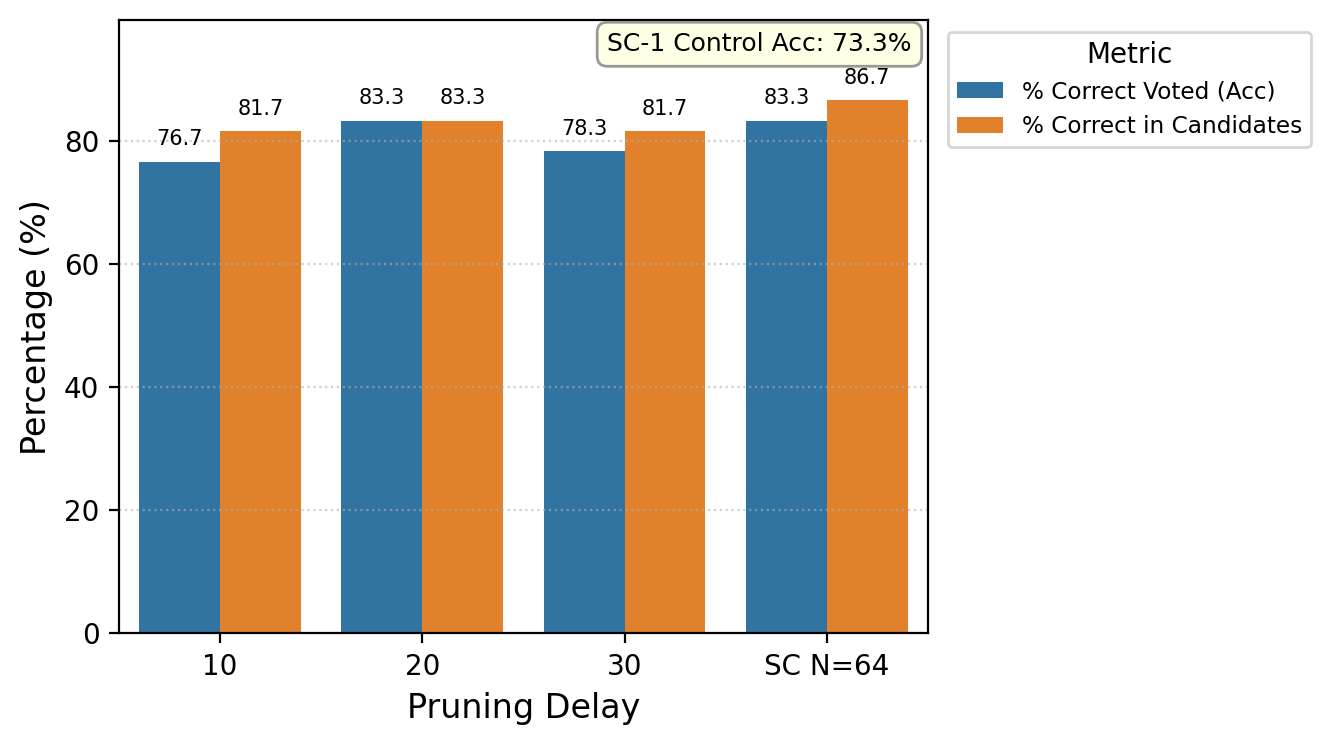

In [7]:
# --- Plotting the Diversity Triple Bar Chart ---

if df_melted_diversity.empty or 'Percentage_Value' not in df_melted_diversity.columns:
    print("No data available to plot the Diversity triple bar chart.")
else:
    plt.figure(figsize=(8, 4)) # Adjusted size for fewer groups
    
    plot_title = f"{NOTEBOOK_TITLE_BASE}\nR1-Distill-Qwen-14B on aime\nDiversity (T0.95, N64) with Pruning Delays vs SC N=64 Control" # Shorter title

    desired_metric_order = [
        "% Correct Voted (Acc)", 
        "% Correct in Candidates",
    ]
    # Filter the desired order to only include metrics actually present in the data
    # This prevents errors if a metric was missing for some reason
    actual_metric_labels_in_data = df_melted_diversity['Metric_Label'].unique()
    metric_hue_order = [label for label in desired_metric_order if label in actual_metric_labels_in_data]


    ax = sns.barplot(
        x='plot_label', 
        y='Percentage_Value', 
        hue='Metric_Label', 
        data=df_melted_diversity,
        palette='tab10', 
        order=diversity_plot_labels_order, 
        errorbar=None, 
        hue_order=metric_hue_order
    )

    ax.set_xlabel("Pruning Delay", fontsize=12) # More general label
    ax.set_ylabel("Percentage (%)", fontsize=12)
    # ax.set_title(plot_title, fontsize=12, pad=10)
    plt.xticks(rotation=0, ha='center', fontsize=10) # No rotation needed now
    plt.yticks(fontsize=10)
    
    # Add value annotations to bars
    for p in ax.patches:
        if pd.notna(p.get_height()) and p.get_height() != 0.0:
            ax.annotate(f"{p.get_height():.1f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 8), 
                        textcoords='offset points', 
                        fontsize=7.5,
                        rotation=0)

    # Add SC-1 Control Accuracy as a text box
    if pd.notna(sc_1_control_accuracy_val):
        sc1_text = f"SC-1 Control Acc: {sc_1_control_accuracy_val:.1f}%"
        ax.text(0.98, 0.98, sc1_text,
                transform=ax.transAxes, 
                fontsize=9, 
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.4', fc='lightyellow', alpha=0.8, edgecolor='gray')) 

    ax.legend(title='Metric', loc='upper left', bbox_to_anchor=(1.01, 1), fontsize='small', title_fontsize='medium')
    ax.grid(True, linestyle=':', alpha=0.6, axis='y')
    
    # Adjust y-axis limits
    current_min_val = df_melted_diversity['Percentage_Value'].min()
    current_max_val = df_melted_diversity['Percentage_Value'].max()
    y_bottom = 0
    if pd.notna(current_min_val) and current_min_val < 0: y_bottom = current_min_val * 1.1 
    y_top = 105 
    if pd.notna(current_max_val) and current_max_val > 100: y_top = current_max_val * 1.1
    elif pd.notna(current_max_val) and current_max_val > 0: y_top = max(current_max_val * 1.15, 20)
    
    if pd.notna(y_bottom) and pd.notna(y_top) and y_top > y_bottom:
        ax.set_ylim(y_bottom, y_top)


    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) 
    # plt.savefig(f"plot_Diversity_Delay_Impact.png", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_2971042/1717363958.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


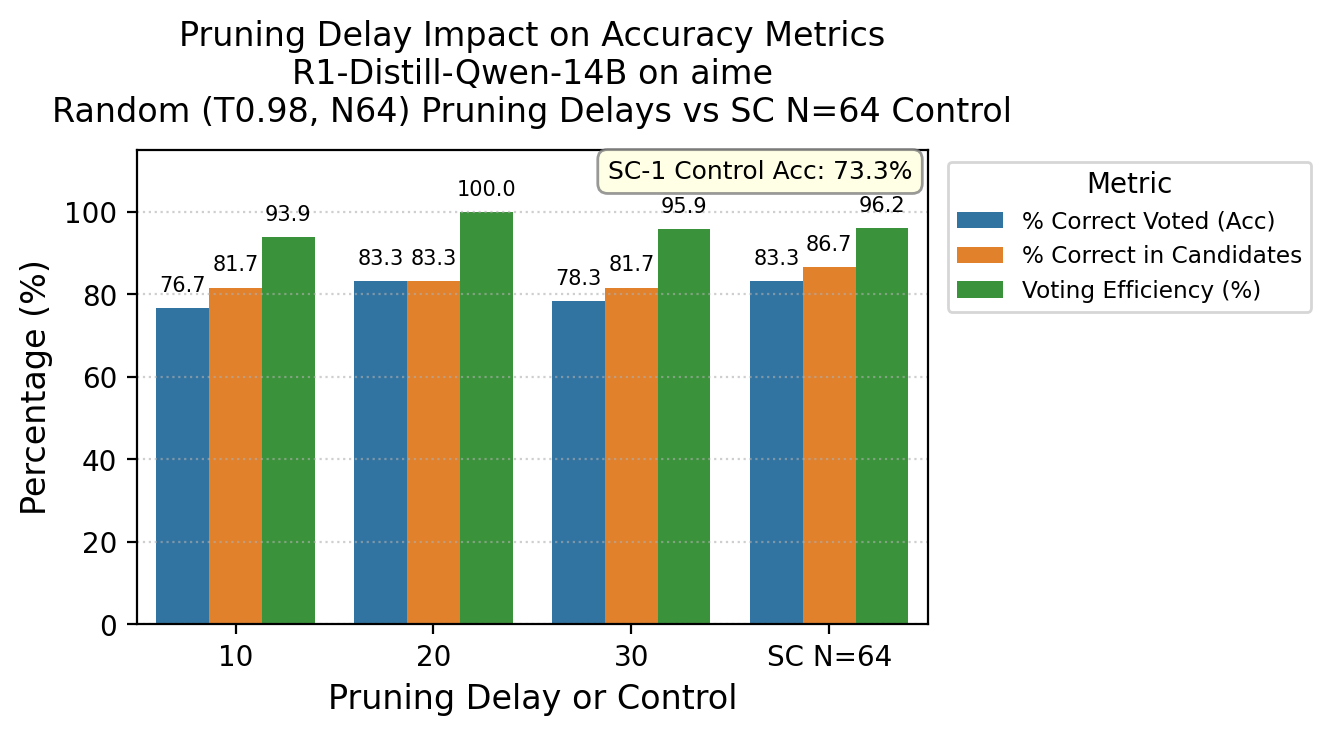

In [63]:
# --- Plotting the Random Triple Bar Chart ---

if df_melted_random.empty or 'Percentage_Value' not in df_melted_random.columns:
    print("No data available to plot the Random triple bar chart.")
else:
    plt.figure(figsize=(8, 4)) # Adjusted size

    plot_title = f"{NOTEBOOK_TITLE_BASE}\nR1-Distill-Qwen-14B on aime\nRandom (T0.98, N64) Pruning Delays vs SC N=64 Control" # Shorter title

    desired_metric_order = [
        "% Correct Voted (Acc)", 
        "% Correct in Candidates",
        "Voting Efficiency (%)"
    ]
     # Filter the desired order to only include metrics actually present in the data
    actual_metric_labels_in_data = df_melted_random['Metric_Label'].unique()
    metric_hue_order = [label for label in desired_metric_order if label in actual_metric_labels_in_data]


    ax = sns.barplot(
        x='plot_label', 
        y='Percentage_Value', 
        hue='Metric_Label', 
        data=df_melted_random,
        palette='tab10', 
        order=random_plot_labels_order,
        ci=None, 
        hue_order=metric_hue_order
    )

    ax.set_xlabel("Pruning Delay or Control", fontsize=12) # More general label
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(plot_title, fontsize=12, pad=10)
    plt.xticks(rotation=0, ha='center', fontsize=10) # No rotation needed now
    plt.yticks(fontsize=10)
    
    # Add value annotations to bars
    for p in ax.patches:
        if pd.notna(p.get_height()) and p.get_height() != 0.0:
            ax.annotate(f"{p.get_height():.1f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 8), 
                        textcoords='offset points', 
                        fontsize=7.5,
                        rotation=0)

    # Add SC-1 Control Accuracy as a text box
    if pd.notna(sc_1_control_accuracy_val):
        sc1_text = f"SC-1 Control Acc: {sc_1_control_accuracy_val:.1f}%"
        ax.text(0.98, 0.98, sc1_text,
                transform=ax.transAxes, 
                fontsize=9, 
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.4', fc='lightyellow', alpha=0.8, edgecolor='gray')) 

    ax.legend(title='Metric', loc='upper left', bbox_to_anchor=(1.01, 1), fontsize='small', title_fontsize='medium')
    ax.grid(True, linestyle=':', alpha=0.6, axis='y')
    
    # Adjust y-axis limits
    current_min_val = df_melted_random['Percentage_Value'].min()
    current_max_val = df_melted_random['Percentage_Value'].max()
    y_bottom = 0
    if pd.notna(current_min_val) and current_min_val < 0: y_bottom = current_min_val * 1.1 
    y_top = 105 
    if pd.notna(current_max_val) and current_max_val > 100: y_top = current_max_val * 1.1
    elif pd.notna(current_max_val) and current_max_val > 0: y_top = max(current_max_val * 1.15, 20)
    
    if pd.notna(y_bottom) and pd.notna(y_top) and y_top > y_bottom:
        ax.set_ylim(y_bottom, y_top)

    plt.tight_layout(rect=[0, 0, 0.85, 0.96]) 
    # plt.savefig(f"plot_Random_Delay_Impact.png", dpi=300, bbox_inches='tight')
    plt.show()